In [3]:
#Ноутбук по мотивам соревнования https://www.kaggle.com/competitions/news-scraping-competition
#Классификация новостей по темам:
#Здоровье/Забота о себе
#Происшествия/Силовые структуры
#Страны бывшего СССР
#Наука
#Спорт
#Туризм/Путешествия
#Общество
#Экономика
#Строительство/Недвижимость

In [1]:
import pandas as pd
from collections import Counter
import fasttext
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler, SequentialSampler)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

#Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#BERT
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AutoModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers.modeling_utils import PreTrainedModel

import re
import numpy as np
import math
from functools import reduce

import time
import datetime
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.preprocessing import normalize


#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('snowball_data')
#nltk.download('perluniprops')
#nltk.download('universal_tagset')
#nltk.download('stopwords')
#nltk.download('nonbreaking_prefixes')
#nltk.download('wordnet')
#from nltk import tokenize
#from nltk.tokenize import word_tokenize

import time
import random
import gc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Preparation

In [5]:
# lenta.ru
care = pd.read_csv('/kaggle/input/lentaru/care_lenta_2012-03-01_2023-12-22.csv') #5
ussr = pd.read_csv('/kaggle/input/lentaru/ex_ussr_lenta_2012-03-01_2023-12-22.csv') #3
police = pd.read_csv('/kaggle/input/lentaru/police_lenta_2012-03-01_2023-12-22.csv') #2
science = pd.read_csv('/kaggle/input/lentaru/science_lenta_2012-03-01_2023-12-22.csv')#8
sport = pd.read_csv('/kaggle/input/lentaru/sport_lenta_2012-03-01_2023-12-22.csv') #4
tourism = pd.read_csv('/kaggle/input/lentaru/tourism_lenta_2012-03-01_2023-12-22.csv') #7
society= pd.read_csv('/kaggle/input/lentaru/society_lenta_2012-03-01_2023-12-22.csv') #0
economy = pd.read_csv('/kaggle/input/lentaru/economy_lenta_2012-03-01_2023-12-22.csv') #1

In [6]:
# ria.ru
realty_list = !ls /kaggle/input/ria-custom-topics/ria_realty
construction_list = !ls /kaggle/input/ria-custom-topics/ria_construction
health_list = !ls /kaggle/input/ria-custom-topics/ria_health
society_list= !ls /kaggle/input/ria-custom-topics/ria_society

cat_dict = {'realty':'ria_realty/', 'construction':'ria_construction/', 'health':'ria_health/', 'society' :'ria_society/'}

base = '/kaggle/input/ria-custom-topics/'

def clean_ria_source(somestring):
    pat = re.compile('([-—]\sРИА\sН(едвижимость|овости)\.)|(\/\sРадио\sSputnik\.)|(\n)')
    somestring = re.sub(pat, '', somestring)
    return somestring

def ria_set(some, cat):
    res = pd.DataFrame()
    for item in some:
        res = pd.concat([pd.read_csv(base+cat_dict[cat]+str(item)), res])
    res = res.rename(columns={'id': 'docid', 'content':'text'})
    res['text'] =  res['text'].apply(lambda x: clean_ria_source(x))
    return res

In [7]:
realty = ria_set(realty_list, 'realty')
construction = ria_set(construction_list, 'construction')
health = ria_set(health_list, 'health')
ria_society = ria_set(society_list, 'society')

In [8]:
#iz.ru
construction_list_iz = !ls /kaggle/input/iz-construction
base = '/kaggle/input/iz-construction/'
res = pd.DataFrame()
for item in construction_list_iz:
     res = pd.concat([pd.read_csv(base+str(item)), res])
        
construction_iz = res.rename(columns={'id': 'docid', 'content':'text'})
construction_iz['text'] =  construction_iz['text'].apply(lambda x: clean_ria_source(x))



In [9]:
construction_iz.head()

,Unnamed: 0,docid,url,title,text,datetime
0,0,1506861,https://iz.ru/1506861/2023-05-02/bank-domrf-na...,Банк ДОМ.РФ назвал размер портфеля проектного ...,Портфель проектного финансирования жилищного с...,2023-05-02T12:03:19+03:00
1,1,1505827,https://iz.ru/1505827/2023-04-28/podriadchika-...,Подрядчика на строительство новой дороги опред...,"В Воронеже определили подрядчика, который займ...",2023-04-28T20:59:11+03:00
2,2,1505782,https://iz.ru/1505782/2023-04-28/bashennyi-kra...,Башенный кран упал на стройке школы в Кирове,"Башенный кран рухнул в Кирове в пятницу, 28 ап...",2023-04-28T19:28:28+03:00
3,3,1505781,https://iz.ru/1505781/2023-04-28/mer-voronezha...,Мэр Воронежа назначил нового главу управления ...,Руководитель Дирекции единого заказчика капита...,2023-04-28T19:23:03+03:00
4,4,1504929,https://iz.ru/1504929/2023-04-27/gosekspertiza...,Госэкспертиза одобрила проект расширения желез...,Главгосэкспертиза одобрила проект реконструкци...,2023-04-27T12:52:27+03:00


In [10]:
construction_iz['text']

0      Портфель проектного финансирования жилищного с...
1      В Воронеже определили подрядчика, который займ...
2      Башенный кран рухнул в Кирове в пятницу, 28 ап...
3      Руководитель Дирекции единого заказчика капита...
4      Главгосэкспертиза одобрила проект реконструкци...
                             ...                        
480    Основной этап строительства третьего энергобло...
481    Губернатор Алтайского края Виктор Томенко попр...
482    В Татарстане на третьем этапе обхода Нижнекамс...
483    Путепровод в селе Дубки Симферопольского район...
484    На проспекте Ленина в Барнауле начался монтаж ...
Name: text, Length: 3086, dtype: object

In [11]:
realty['text']

0      СОЧИ, 2 ноя  Самый большой фудхолл сети Eat Ma...
1      МОСКВА, 2 ноя  Президент России Владимир Путин...
2      МОСКВА, 2 ноя  Альфа-банк открыл Setl Group кр...
3      МОСКВА, 2 ноя  Краснодарская компания "Консалт...
4      МОСКВА, 2 ноя  X5 Group, управляющая сетями "П...
                             ...                        
972    СОЧИ, 2 ноя  Фудхоллы Eat Market могут появить...
973    МОСКВА, 2 ноя  Межрегиональное территориальное...
974    МОСКВА, 2 ноя  Президент России Владимир Путин...
975    СОЧИ, 2 ноя  Сеть турецких ресторанов Big Chef...
976    МОСКВА, 2 ноя  Вторичное жилье в крупных росси...
Name: text, Length: 6128, dtype: object

In [12]:
realty = pd.concat([realty, construction, construction_iz], ignore_index=True)
society = pd.concat([society, ria_society], ignore_index=True)
care = pd.concat([health, care], ignore_index=True)

In [13]:
care.loc[:, 'target'] = 5
ussr.loc[:, 'target'] = 3
police.loc[:, 'target'] = 2
science.loc[:, 'target'] = 8
sport.loc[:, 'target'] = 4
tourism.loc[:, 'target'] = 7
society.loc[:, 'target'] = 0
economy.loc[:, 'target'] = 1
realty.loc[:, 'target'] = 6


In [14]:
realty.drop_duplicates(['text', 'title'], inplace=True)
care.drop_duplicates(['text', 'title'], inplace=True)
society.drop_duplicates(['text', 'title'], inplace=True)

In [15]:
lens = []
for item in [care, ussr, police, science, sport, tourism, society, economy, realty]:
    lens.append(len(item))
lens

[14522, 70248, 53269, 52710, 65520, 28643, 109656, 73008, 12218]

In [16]:
minlen = min(lens)


In [17]:
#балансируем обучающую выборку
n = minlen
care =  care.sample(n)
ussr = ussr.sample(n)
police = police.sample(int(2*n))
science = science.sample(n)
sport = sport.sample(n)
tourism = tourism.sample(n)
society = society.sample(3*n)
economy = economy.sample(n)
realty = realty.sample(n)

In [18]:
cols_to_keep = ['docid','url', 'title', 'text', 'target']

In [19]:
df = pd.concat([care, ussr, police, science, sport, tourism, society, economy, realty], ignore_index=True)
df = df[cols_to_keep]

In [20]:
df['titletext'] = df['title'] + ' ' + df['text']

In [21]:
df.target.value_counts()

target
0    36654
2    24436
5    12218
3    12218
8    12218
4    12218
7    12218
1    12218
6    12218
Name: count, dtype: int64

In [22]:
df.shape

(146616, 6)

In [23]:
df.isna().any().sum()

0

In [24]:
df.head()

,docid,url,title,text,target,titletext
0,1376782,https://lenta.ru/news/2023/01/30/segel/,Звезда сериала «Как я встретил вашу маму» расс...,Фото: Billy Bennight / AdMedia / Globallookpre...,5,Звезда сериала «Как я встретил вашу маму» расс...
1,1355190,https://lenta.ru/news/2022/12/15/pelmeni/,Диетолог назвала способ есть пельмени и не тол...,Фото: Alex Hu / Unsplash Александра Лисица До ...,5,Диетолог назвала способ есть пельмени и не тол...
2,1396934,https://lenta.ru/news/2023/03/09/fat/,Диетолог назвала помогающие сжигать жир продукты,"Фото: Unsplash Марина Совина Врач-диетолог, те...",5,Диетолог назвала помогающие сжигать жир продук...
3,1293235,https://lenta.ru/news/2022/08/19/otpusk/,Тренер подсказал способ похудеть после отпуска...,Фото: Trust Katsande / Unsplash Александра Лис...,5,Тренер подсказал способ похудеть после отпуска...
4,1351294,https://lenta.ru/news/2022/12/09/relationshipw...,Коучи назвали способы оценить жизнеспособность...,Фото: Shutterstock Алиса Дмитриева Прежде чем ...,5,Коучи назвали способы оценить жизнеспособность...


In [25]:
data_trainval, data_test = train_test_split(df, stratify=df['target'], test_size=0.25, random_state = 112)
data_train, data_val = train_test_split(data_trainval, stratify=data_trainval['target'], test_size=0.1, random_state = 112)

In [26]:
data_train.to_csv('data_train.csv')
data_test.to_csv('data_test.csv')
data_val.to_csv('data_val.csv')


In [27]:
debugtrain = data_train.sample(100)
debugval = data_val.sample(20)

## Pretrained Embeddings 

In [6]:
MAX_LEN = 312 #312 for sentence embeddings,  2048 for word embeddings
MODEL_PATH = 'cointegrated/rubert-tiny2'
BATCH_SIZE=64



In [31]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('cointegrated/rubert-tiny2')

  Obtaining dependency information for sentence-transformers from https://files.pythonhosted.org/packages/76/2c/bd95032aeb087b0706596af0a4518c4bfe0439a1bb149048ece18b617766/sentence_transformers-2.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 2.0 MB/s eta 0:00:00a 0:00:01m


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [32]:
bert =   SentenceTransformer('cointegrated/rubert-tiny2')

In [35]:
from spacy.lang.ru import Russian

nlp = Russian()
nlp.add_pipe("sentencizer")


## LSTM

In [7]:
MAX_SEQ_LEN = 50 # обрезаем тексты статей до 50 предложений 

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    pad = torch.zeros(312)
    def __init__(self, texts, targets, model):
        self.texts = texts
        self.targets = targets
        self.encoder = model
        
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        texts = self.texts[idx]
        target = self.targets[idx]
        
        sents = [sent.text for sent in nlp(texts).sents] 
            
        if len(sents) > MAX_SEQ_LEN:
            sents = sents[:MAX_SEQ_LEN]
            
        encoding = torch.FloatTensor(self.encoder.encode(sents, show_progress_bar=False))
        
        if len(sents) < MAX_SEQ_LEN:  #padding
            pad = torch.zeros((MAX_SEQ_LEN - len(sents), 312))
            encoding = torch.cat([encoding,pad], dim = 0) 
        return {
           'text': texts,
           'input': encoding,
           'targets': torch.tensor(target, dtype=torch.long)
            }

In [4]:
HIDDEN_DIM = 300
N_LAYERS = 4
BIDIRECTIONAL = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [8]:
class LSTMClassifier(nn.Module):

    def __init__(self,  n_classes=9, embedding_dim=MAX_LEN, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS, bidirectional=BIDIRECTIONAL
     ):
         
        super().__init__() 
                
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout = 0.3,
            batch_first=True,
        )
        self.output_dim = n_classes
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, self.output_dim)
     
        self.func = nn.Tanh()
    
    def forward(self, inputs): 
             
        outputs, (hidden, cell) = self.lstm(inputs)
        
        outputs = torch.mean(outputs, dim=1)
        
        outputs = self.fc(self.func(outputs))
             
        return outputs
        

In [35]:
train_dataset = CustomDataset(list(data_train['titletext']), targets=list(data_train['target']), model=bert)
val_dataset = CustomDataset(list(data_val['titletext']), targets=list(data_val['target']), model=bert)

    # create data loaders
train_data = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_data =  DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
test_dataset = CustomDataset(list(data_test['titletext']), targets=list(data_test['target']), model=bert)
test_data = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [37]:
# debug datasets
#debug_train_dataset = CustomDataset(list(debugtrain['titletext']), targets=list(debugtrain['target']), model=bert)
#debug_val_dataset = CustomDataset(list(debugval['titletext']), targets=list(debugval['target']), model=bert)

    
#debug_train_data = DataLoader(debug_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#debug_val_data =  DataLoader(debug_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [38]:
#next(iter(debug_train_data))

In [9]:
    
def fit(model, train_loader, optimizer, epochs):
    
    losses = []
    correct_predictions = 0
    model.train()
    
    loss_fn = torch.nn.CrossEntropyLoss().to(device)
    
    for data in train_loader:
        
        optimizer.zero_grad()
        targets = data["targets"]
        targets = targets.to(device)
        inputs = data['input'].to(device)
        
        
        outputs = model(inputs).to(device)
        loss = loss_fn(outputs.to(torch.float32), targets)
        loss.backward()
        losses.append(loss.item())
        
        correct_predictions += torch.sum(torch.argmax(outputs, dim=1) == targets)  
               
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
       
    train_acc = correct_predictions.double() / len(train_dataset)
    train_loss = np.mean(losses)
        
    return train_acc, train_loss
    
def eval(model, valid_loader):
    model.eval()
    losses = []
    correct_predictions = 0
    
    loss_fn = torch.nn.CrossEntropyLoss().to(device)
    
    with torch.no_grad():
        for data in valid_loader:
            targets = data["targets"]
            targets = targets.to(device)
            inputs = data['input'].to(device)
        
            outputs = model(inputs).to(device)
            loss = loss_fn(outputs.to(torch.float32), targets)
    
  
            correct_predictions += torch.sum(torch.argmax(outputs, dim=1) == targets)
            losses.append(loss.item())
    
        val_acc = correct_predictions.double() / len(val_dataset)
        val_loss = np.mean(losses)
        return val_acc, val_loss
    
def train(model, train_loader, valid_loader, optimizer, epochs):
        
        best_accuracy = 0
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = fit(model, train_loader, optimizer, epochs)
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = eval(model, valid_loader)
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(model,'/kaggle/working/model.pt')
                torch.save(model.state_dict(),'/kaggle/working/model_state.pt')
                best_accuracy = val_acc

        
        

        

In [ ]:
model = LSTMClassifier()
model = nn.DataParallel(model)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

In [37]:
#Сеть обучалась в несколько итераций, последняя итерация (всего около 20 эпох):
train(model, train_data, val_data, optimizer, epochs=5)

Epoch 1/5
Train loss 0.5142954491806092 accuracy 0.8127822967715859
Val loss 0.4970660556194394 accuracy 0.8206783668273165
----------
Epoch 2/5
Train loss 0.48340888312730623 accuracy 0.8242914161572272
Val loss 0.48295478921296986 accuracy 0.8221333090842957
----------
Epoch 3/5
Train loss 0.47232289001605704 accuracy 0.8271510129843884
Val loss 0.46686513358077336 accuracy 0.8269528053105392
----------
Epoch 4/5
Train loss 0.4611005165361942 accuracy 0.8313343101096347
Val loss 0.4535564150401326 accuracy 0.8326816404473947
----------
Epoch 5/5
Train loss 0.45249795793292596 accuracy 0.8343252665083615
Val loss 0.4649333415856195 accuracy 0.8305901609529871
----------


In [37]:
    
def predict(model, test_loader):
    model.eval()
       
    with torch.no_grad():
        total_test_samples = 0
        correct_predictions = 0

        predicted_labels_list = []
        targets_list = []
        for data in test_loader:
        
            targets = data["targets"]
            targets = targets.to(device)
            inputs = data['input'].to(device)
        
            outputs = model(inputs).to(device)

            predicted_labels = torch.argmax(outputs, dim=1)

            total_test_samples += len(inputs)
            correct_predictions += (predicted_labels == targets).sum().item()

            predicted_labels_list.extend(predicted_labels.tolist())
            targets_list.extend(targets.tolist())

        print(classification_report(targets_list, predicted_labels_list))
        return predicted_labels_list

In [ ]:
#model=torch.load('/kaggle/working/model2.pt').module

In [39]:
preds = predict(model, test_data)

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      9164
           1       0.84      0.88      0.86      3054
           2       0.79      0.86      0.82      6109
           3       0.74      0.82      0.77      3055
           4       0.97      0.94      0.96      3055
           5       0.90      0.94      0.92      3055
           6       0.94      0.95      0.94      3054
           7       0.86      0.93      0.90      3054
           8       0.90      0.85      0.87      3054

    accuracy                           0.85     36654
   macro avg       0.86      0.88      0.87     36654
weighted avg       0.85      0.85      0.84     36654



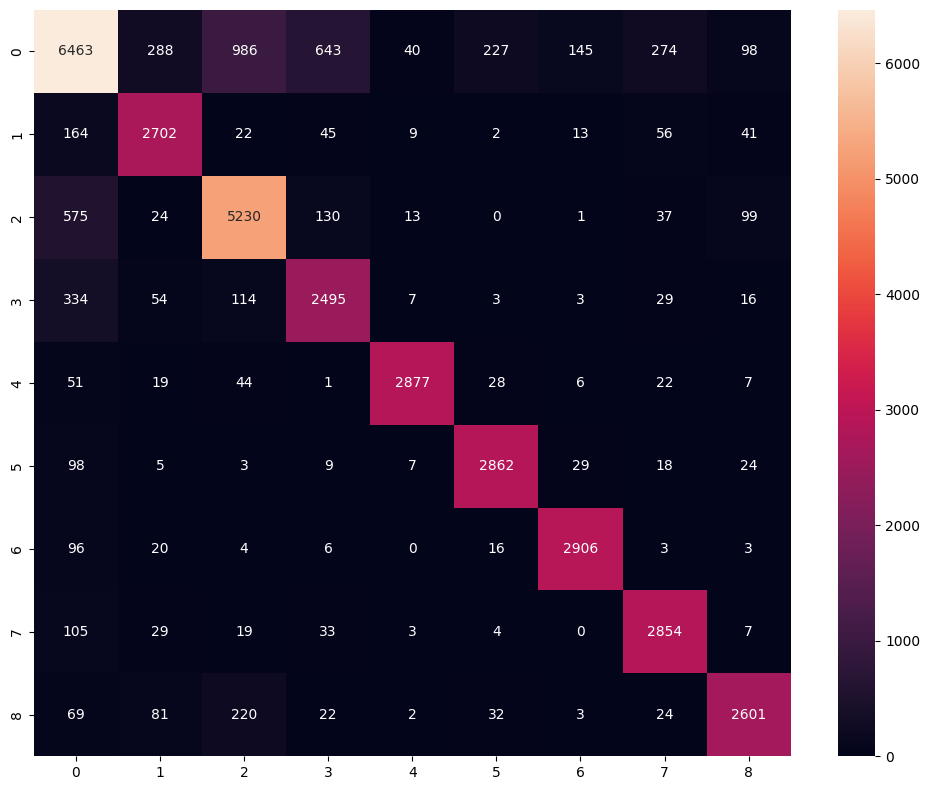

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(data_test['target'], preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")

tick_marks = np.arange(9)
plt.tight_layout()
plt.show()